In [1]:
# Importing neccessary libraries
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, date, time
%matplotlib inline

In [2]:
# Loading formatted data
data_folder = '../data/generated/'
actor_df = pd.read_pickle(data_folder + 'actor_df.pkl')
appears_in_df = pd.read_pickle(data_folder + 'appears_in_df.pkl')
belongs_to_df = pd.read_pickle(data_folder + 'belongs_to_df.pkl')
character_df = pd.read_pickle(data_folder + 'character_df.pkl')
comes_from_df = pd.read_pickle(data_folder + 'comes_from_df.pkl')
country_df = pd.read_pickle(data_folder + 'country_df.pkl')
genre_df = pd.read_pickle(data_folder + 'genre_df.pkl')
is_of_type_df = pd.read_pickle(data_folder + 'is_of_type_df.pkl')
language_df = pd.read_pickle(data_folder + 'language_df.pkl')
movie_df = pd.read_pickle(data_folder + 'movie_df.pkl')
play_df = pd.read_pickle(data_folder + 'play_df.pkl')
spoken_languages_df = pd.read_pickle(data_folder + 'spoken_languages_df.pkl')

In [3]:
movie_df['release_year'] = pd.to_datetime(movie_df.release_date, errors='coerce') # If missing day and month, -> YYYY-01-01

In [4]:
movie_df['release_year'] = movie_df.release_year.dt.strftime('%Y') # format date to year for seaborn
movie_df = movie_df.dropna(subset=['release_year']) # drop missing year release
movie_df = movie_df.sort_values(by='release_year') # sort by year

In [5]:
movie_actor = pd.merge(pd.merge(actor_df, appears_in_df, on='actor_id'), movie_df, on='movie_id') # 436'509 actors
movie_actor = movie_actor.sort_values('release_year')

In [6]:
movie_actor.head()

,actor_id,name_x,gender,height,ethnicity,birth_date,movie_id,actor_age,name_y,release_date,revenue,runtime,freebase_id,plot,release_year
424066,/m/0k2pzd,Harriet Hartley,F,NaN,NaN,NaN,1082508,NaN,Roundhay Garden Scene,1888,NaN,0.03,/m/044ggd,NaN,1888
424065,/m/0k2pz6,Joseph Whitley,M,NaN,NaN,NaN,1082508,NaN,Roundhay Garden Scene,1888,NaN,0.03,/m/044ggd,NaN,1888
424064,/m/0k2pz0,Sarah Whitley,F,NaN,NaN,NaN,1082508,NaN,Roundhay Garden Scene,1888,NaN,0.03,/m/044ggd,NaN,1888
424063,/m/0k2pyv,Adolphe Le Prince,M,NaN,NaN,NaN,1082508,NaN,Roundhay Garden Scene,1888,NaN,0.03,/m/044ggd,NaN,1888
415686,/m/081ks,William Dickson,M,NaN,/m/03lmx1,1860-08-03,644824,NaN,Dickson Greeting,1891,NaN,0.05,/m/02_1qn,NaN,1891


## COMPARAISON AGE HOMME-FEMME

In [7]:
men_actor = movie_actor[movie_actor['gender'] == 'M']
men_actor_age = men_actor.dropna(subset=['actor_age'])[['actor_age', 'release_year']]
men_actor_age = men_actor_age[(men_actor_age['actor_age'] > 0)] 
men_actor_age = men_actor_age.sort_values('release_year')

In [8]:
women_actor = movie_actor[movie_actor['gender'] == 'F']
women_actor_age = women_actor.dropna(subset=['actor_age'])[['actor_age', 'release_year']]
women_actor_age = women_actor_age[(women_actor_age['actor_age'] > 0)] 
women_actor_age = women_actor_age.sort_values('release_year')

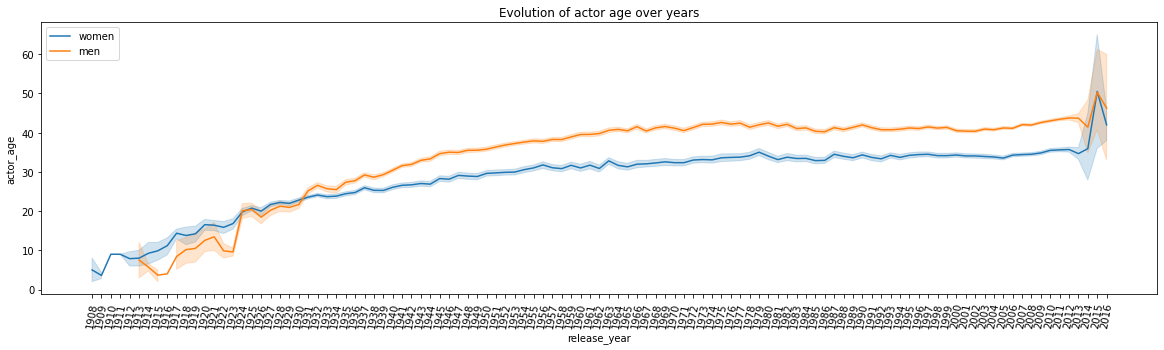

In [34]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Evolution of actor age over years')
sns.lineplot(data=women_actor_age, x='release_year', y='actor_age',legend='brief', label='women')
sns.lineplot(data=men_actor_age, x='release_year', y='actor_age',legend='brief', label='men')
plt.legend(loc='upper left')
ax.tick_params(axis='x', rotation=80)

# comparaison apparition homme femmes dans genre de film

In [35]:
men_genre = pd.merge(men_actor, is_of_type_df, on='movie_id')[['release_year', 'genre_name']]
m_set = list(men_genre.genre_name.value_counts()[:17].index)

In [36]:
women_genre = pd.merge(women_actor, is_of_type_df, on='movie_id')[['release_year', 'genre_name']]
w_set = list(women_genre.genre_name.value_counts()[:17].index)

In [37]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [38]:
list_genres = intersection(m_set, w_set)
list_genres

['drama',
 'comedy',
 'action',
 'thriller',
 'romance film',
 'crime fiction',
 'action/adventure',
 'world cinema',
 'adventure',
 'indie',
 'black-and-white',
 'horror',
 'family film',
 'musical',
 'romantic drama',
 'mystery']

In [39]:
men_genre = men_genre[men_genre['genre_name'].isin(list_genres)]
women_genre = women_genre[women_genre['genre_name'].isin(list_genres)]

In [40]:
men_genre = men_genre.groupby('genre_name').apply(lambda x: pd.Series({
        'release_year': x['release_year'].values
    }))

In [41]:
list(men_genre.iloc[0].values[0])[0]

'1903'

In [43]:
women_genre

,release_year,genre_name
1,1888,black-and-white
3,1888,indie
5,1888,black-and-white
7,1888,indie
9,1894,black-and-white
...,...,...
502192,2015,action
502195,2016,thriller
502196,2016,horror
502197,2016,thriller


# je veux faire la moyenne du ratio de personnage masculin/féminin par genre de film

In [44]:
actors = movie_actor[['gender', 'movie_id']]
actors.groupby('movie_id').head()
actors['gender'].replace(['M','F'], [0,1], inplace=True)
actors.rename(columns={"gender": "female"}, inplace=True)
actors['male'] = 1-actors['female']
actors

/tmp/ipykernel_5167/896721564.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actors['gender'].replace(['M','F'], [0,1], inplace=True)
/tmp/ipykernel_5167/896721564.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actors.rename(columns={"gender": "female"}, inplace=True)
/tmp/ipykernel_5167/896721564.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actors['male'] = 1-ac

,female,movie_id,male
424066,1.0,1082508,0.0
424065,0.0,1082508,1.0
424064,1.0,1082508,0.0
424063,0.0,1082508,1.0
415686,0.0,644824,1.0
...,...,...,...
303752,0.0,23124260,1.0
303750,0.0,23124260,1.0
303749,0.0,23124260,1.0
303748,0.0,23124260,1.0


In [45]:
count_genre = actors.groupby('movie_id').sum()
count_genre

,female,male
movie_id,,
330,4.0,0.0
3217,3.0,7.0
3333,6.0,8.0
3746,3.0,11.0
3837,2.0,18.0
...,...,...
37373877,3.0,3.0
37476824,4.0,6.0
37478048,1.0,3.0


In [46]:
count_genre['diff'] = count_genre['male'] - count_genre['female']
count_genre

,female,male,diff
movie_id,,,
330,4.0,0.0,-4.0
3217,3.0,7.0,4.0
3333,6.0,8.0,2.0
3746,3.0,11.0,8.0
3837,2.0,18.0,16.0
...,...,...,...
37373877,3.0,3.0,0.0
37476824,4.0,6.0,2.0
37478048,1.0,3.0,2.0


In [47]:
diff_genre = count_genre['diff']
diff_genre

movie_id
330         -4.0
3217         4.0
3333         2.0
3746         8.0
3837        16.0
            ... 
37373877     0.0
37476824     2.0
37478048     2.0
37492363     0.0
37501922     0.0
Name: diff, Length: 60554, dtype: float64

In [48]:
movie_genre = pd.merge(movie_df, is_of_type_df, on='movie_id')
movie_genre = pd.merge(movie_genre, diff_genre, on='movie_id')[['release_year', 'genre_name', 'diff']]
movie_genre = movie_genre.groupby(['release_year', 'genre_name']).mean()
movie_genre

diff
release_year genre_name           
1888         black-and-white   0.0
             indie             0.0
             short film        0.0
             silent film       0.0
1891         indie             1.0
...                            ...
2015         crime fiction     4.0
             fantasy          -1.0
             science fiction   1.5
2016         horror            2.0
             thriller          2.0

[13460 rows x 1 columns]

In [24]:
movie_genre.reset_index()[['genre_name', 'diff']].groupby('genre_name').mean().sort_values('diff')

,diff
genre_name,
c-movie,-2.000000
health & fitness,-1.333333
women in prison films,-1.312500
romantic thriller,-1.000000
war effort,-1.000000
...,...
prison film,9.545455
the netherlands in world war ii,10.000000
ninja movie,10.000000


In [59]:
movie_genre

diff
release_year genre_name           
1888         black-and-white   0.0
             indie             0.0
             short film        0.0
             silent film       0.0
1891         indie             1.0
...                            ...
2015         crime fiction     4.0
             fantasy          -1.0
             science fiction   1.5
2016         horror            2.0
             thriller          2.0

[13460 rows x 1 columns]

In [73]:
movie_genre.xs(list_genres[0], level = 'genre_name')

,diff
release_year,
1896,1.000000
1899,-1.000000
1900,-1.000000
1901,1.000000
1902,5.000000
...,...
2010,2.632406
2011,2.692098
2012,2.190860


<AxesSubplot:xlabel='release_year', ylabel='diff'>

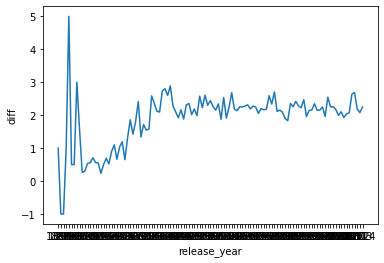

In [81]:
sns.lineplot(data = movie_genre.xs(list_genres[0], level = 'genre_name'), x='release_year', y='diff')

Text(0, 0.16, 'Difference of number of men and women characters')

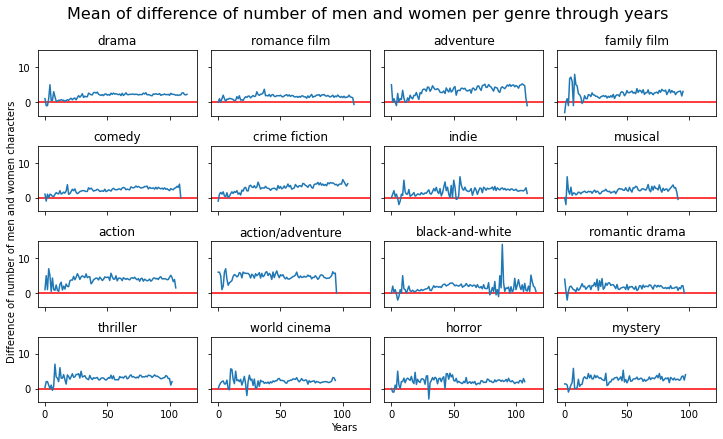

In [78]:
fig, ax = plt.subplots(4,4,figsize= (10,6), sharey = True, sharex = True)
fig.suptitle('Mean of difference of number of men and women per genre through years', fontsize=16)

for i in range(16):
    sbplt = ax[i%4, math.floor(i/4)]
    sbplt.axhline(y=0, color='r', linestyle='-')
    sbplt.plot(movie_genre.xs(list_genres[i], level='genre_name').values)
    #sbplt.xticks(range(100, 200))
    sbplt.set_title(list_genres[i])
    
fig.tight_layout()

fig.text(0.45,0, "Years")
fig.text(0, 0.16, "Difference of number of men and women characters", rotation = 90)

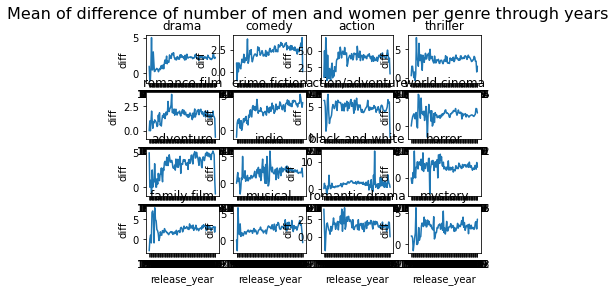

In [94]:
fig, axes = plt.subplots(4,4)
fig.suptitle('Mean of difference of number of men and women per genre through years', fontsize=16)
sns.set()
points = list()
for i in range(4):
    for j in range(4):
        points.append((i, j))
for g, p in enumerate(points):
    sns.lineplot(data = movie_genre.xs(list_genres[g], level = 'genre_name'), x='release_year', y='diff', ax = axes[p]).set(title=list_genres[g])

In [26]:
print(len(movie_genre[movie_genre['diff'] > 0]))
print(len(movie_genre[movie_genre['diff'] < 0]))
print(len(movie_genre[movie_genre['diff'] == 0]))

12081
805
574
